In this notebook, we will try using autoencoders to solve the anomaly detection problem. For data exploring and a solution using linear regression, please take a look on the notebook data_exploring_linear_model.

In [81]:
import numpy as np
import pandas as pd

In [82]:
df = pd.read_csv('data/T1.csv')

In [83]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [84]:
# Rename columns
df = df.rename(columns = {'LV ActivePower (kW)'	: 'ActivePower'})
df = df.rename(columns = {'Theoretical_Power_Curve (KWh)'	: 'TheoreticalPower'})
df = df.rename(columns = {'Wind Direction (°)'	: 'WindDirection'})
df = df.rename(columns = {'Wind Speed (m/s)'	: 'WindSpeed'})

In [85]:
# Convert Date/Time feature to format day-month-year hour:minute
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format = '%d %m %Y %H:%M')
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time

In [86]:
# Split date data
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [87]:
# Add the season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 3
    elif month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    else: 
        return 2

In [88]:
df['Season'] = df['Month'].apply(get_season)

In [89]:
# Sort the unique time values and create a mapping of sorted times to numerical labels
sorted_times = sorted(df['Time'].unique())
time_to_label = {time: label for label, time in enumerate(sorted_times)}

# Map the 'Time' column to its numerical label based on the sorted order
df['EncodedTime'] = df['Time'].map(time_to_label)

In [90]:
df.drop(columns=['Date/Time', 'Date', 'Time'], inplace=True)

In [91]:
df.head()

,ActivePower,WindSpeed,TheoreticalPower,WindDirection,Day,Month,Year,Season,EncodedTime
0,380.047791,5.311336,416.328908,259.994904,1,1,2018,3,0
1,453.769196,5.672167,519.917511,268.641113,1,1,2018,3,1
2,306.376587,5.216037,390.900016,272.564789,1,1,2018,3,2
3,419.645905,5.659674,516.127569,271.258087,1,1,2018,3,3
4,380.650696,5.577941,491.702972,265.674286,1,1,2018,3,4


In [92]:
X = df.values
y = df.values

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [95]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40424, 9)
(40424, 9)
(10106, 9)
(10106, 9)


We have done a data preprocessing for the model. Let's now define the model.

In [97]:
import tensorflow as tf
from tensorflow import keras
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      keras.layers.Dense(4, activation='relu',input_shape=(input_dim,)),
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(8, activation='relu'),
      keras.layers.Dense(input_dim),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

In [98]:
input_dim = X_train.shape[1]

model = Autoencoder(input_dim)
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [99]:
# Traing the model
model.fit(x = tf.convert_to_tensor(X_train), y = tf.convert_to_tensor(X_train)  , batch_size=64, epochs=3)

Epoch 1/3


632/632 [==============================] - 2s 1ms/step - loss: 516541.1250
Epoch 2/3
632/632 [==============================] - 1s 1ms/step - loss: 10350.1934
Epoch 3/3
632/632 [==============================] - 1s 1ms/step - loss: 4461.2192


In [100]:
# Define a function to plot the results
import matplotlib.pyplot as plt
import seaborn as sns
def point_plot(y_pred, y_true, title, range = 200, start_index = 0):
    plt.figure(figsize=(14,6))
    sns.pointplot(
        x = np.arange(range),
        y = y_pred[start_index : start_index + range],
        label = 'predicted values',
        color = 'red'
    )
    sns.pointplot(
        x = np.arange(range),
        y = y_true[start_index : start_index + range],
        label = 'actual values',
        color = 'blue'
    )
    plt.title(title)
    plt.legend()
    plt.show()

In [101]:
X_train_tf = tf.convert_to_tensor(X_train)
y_train_predict = model.predict(X_train_tf)

1264/1264 [==============================] - 1s 957us/step


Plot the results for training set.

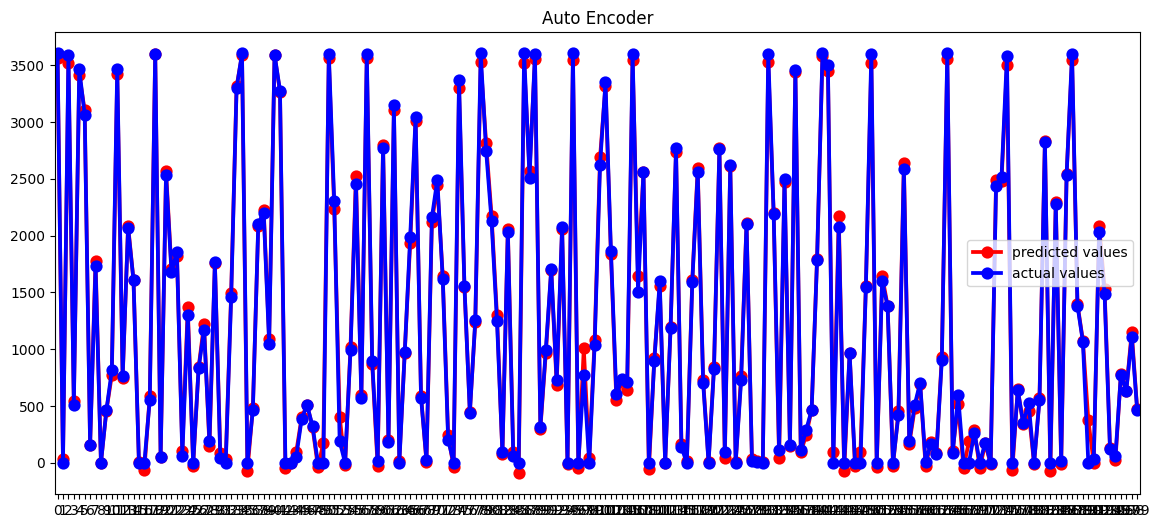

In [102]:
point_plot(y_pred = y_train_predict[:,0], y_true = X_train[:,0],start_index = 300,range = 200,title = "Auto Encoder")

Let's try it on test set.

In [103]:
X_test_tf = tf.convert_to_tensor(X_test)
y_test_predict = model.predict(X_test_tf)

316/316 [==============================] - 0s 1ms/step


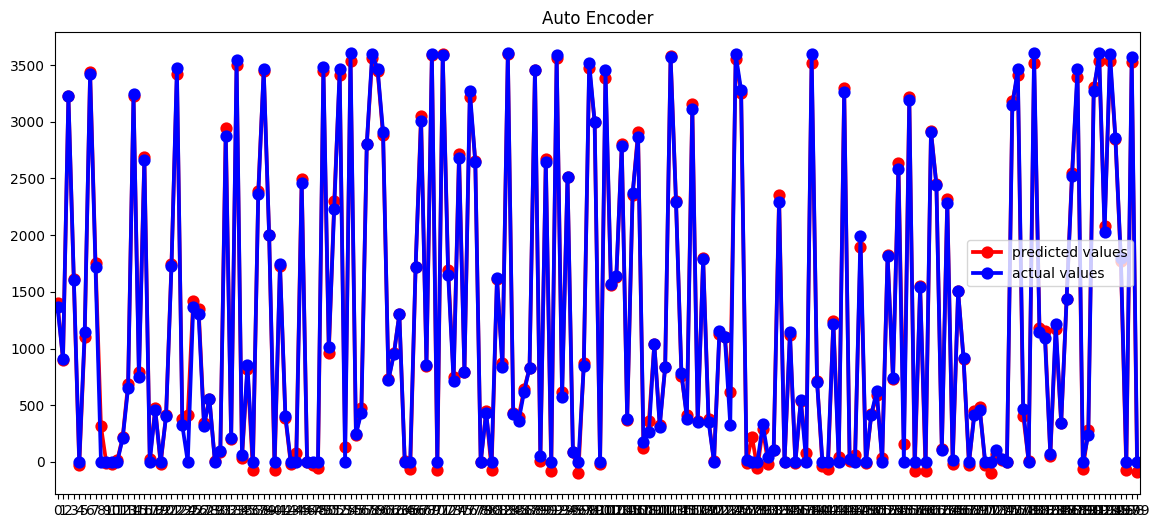

In [104]:
point_plot(y_pred = y_test_predict[:,0], y_true = X_test[:,0],start_index = 300,range = 200,title = "Auto Encoder")

Let's plot the residuals.

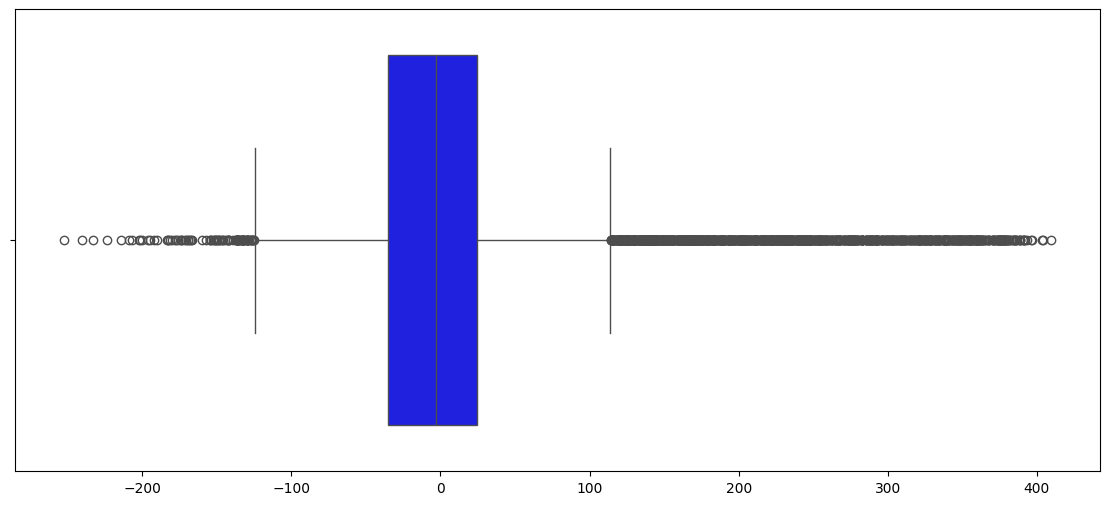

In [105]:
train_residuals = y_train_predict[:, 0] - X_train[:, 0]
plt.figure(figsize=(14,6))
sns.boxplot(
    x = train_residuals,
    color = 'b'
)
plt.show()

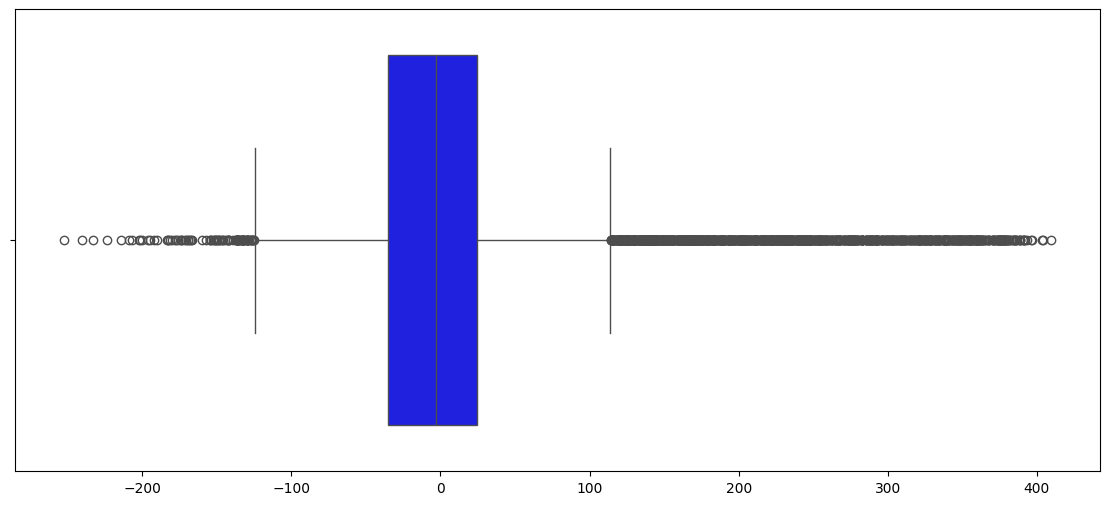

In [106]:
test_residuals = y_train_predict[:, 0] - X_train[:, 0]
plt.figure(figsize=(14,6))
sns.boxplot(
    x = test_residuals,
    color = 'b'
)
plt.show()

The result is quite close to the linear model. When actual active power - predicted value < -100 or actual active power - predicted value > 100, there should be anomalies.